In [1]:
import matplotlib
from pylab import *
import math
from collections import OrderedDict

In [2]:
def get_id(i, j):
    return str(i) + "," + str(j)


def val(value):
    return round(value, 3)


def percent(value):
    return round(value * 100, 2)


class GraphStep:
    def __init__(self, i):
        self.i = i
        self.nodes = []
        self.a = 0

    def as_json(self):
        dict = OrderedDict()
        dict['i'] = self.i
        dict['a'] = val(self.a)
        dict['nodes'] = [ob.as_json() for ob in self.nodes]
        return dict


class GraphNode:
    def __init__(self, i=0, j=0, pu="", pm="", pd="", rate=0, j_up=0, j_m=0, j_d=0):
        self.id = get_id(i, j)
        self.i = i
        self.j = j
        self.rate = rate
        self.j_up = j_up
        self.j_m = j_m
        self.j_d = j_d
        self.pu = pu
        self.pd = pd
        self.pm = pd
        if i == 0 and self.j == 0:
            self.q = 1
        else:
            self.q = 0

    def get_rate(self):
        return str(val(self.rate * 100)) + "%"

    def as_json(self):
        dict = OrderedDict()
        dict['i'] = self.i
        dict['j'] = self.j
        dict['rate'] = str(percent(self.rate)) + " %"
        dict['q'] = val(self.q)
        dict['j_up'] = self.j_up
        dict['j_m'] = self.j_m
        dict['j_d'] = self.j_d
        dict['pu'] = val(self.pu)
        dict['pm'] = val(self.pm)
        dict['pd'] = val(self.pd)
        return dict


class HWCalculator:
    def __init__(self):
        self.steps = []
        self.jmax = 0
        self.maturity = 0
        self.period = 'year'
        self.nbr_steps = 1
        self.volatility = 0.0
        self.alpha = 0.0
        self.rates = []

    def as_json(self):
        dict = OrderedDict()
        dict['maturity'] = self.maturity
        dict['jmax'] = self.jmax
        dict['period'] = self.period
        dict['nbr_steps'] = self.nbr_steps
        dict['volatility'] = self.volatility
        dict['alpha'] = self.alpha
        dict['rates'] = self.rates
        dict['steps'] = [ob.as_json() for ob in self.steps]

        return dict

    def execute(self):
        if self.nbr_steps == 0:
            self.nbr_steps = 1.0
        dt = float(self.maturity) / float(self.nbr_steps)
        return self.process(self.volatility, self.alpha, dt, self.nbr_steps, self.rates)

    def process(self, sig, alpha, dt, N, rates):
        # Init parameter

        M = -alpha * dt
        dr = sig * math.sqrt(3 * dt)
        jmax = int(math.ceil(-0.1835 / M))
        jmin = -jmax
        self.jmax = jmax

        # Create empty graph

        self.steps = self.create_graph(N, jmax)

        # Calculate probability

        self.init_standard_move(N, jmax, self.steps, dr)

        self.compute_transition_probability(N, jmax, jmin, M, self.steps)

        P = []
        P.append(1)
        for i in range(1, len(rates) + 1):
            P.append(math.exp(-rates[i - 1] * i * dt))

        self.steps[0].a = -math.log(P[1]) / dt
        for node in self.steps[0].nodes:
            node.rate += self.steps[0].a

        for i in range(1, N, 1):
            top_node = min(i, jmax)
            current_step = self.steps[i]
            for j in range(-top_node, top_node + 1, 1):
                current_node = current_step.nodes[j + top_node]
                connected_nodes = self.find_connected_node(current_node, self.steps[i - 1].nodes)
                self.compute_arrow(current_node, connected_nodes, self.steps[i - 1].a, dt, dr)
            sum = 0
            for j in range(-top_node, top_node + 1, 1):
                node = self.steps[i].nodes[j + top_node]
                sum += node.q * math.exp(-j * dt * dr)

            current_step.a = (math.log(sum) - math.log(P[i + 1])) / dt

            for j in range(-top_node, top_node + 1, 1):
                current_step.nodes[j + top_node].rate += current_step.a

    def create_graph(self, N, jmax):
        hwsteps = []
        for i in range(0, N, 1):
            top_node = min(i, jmax)
            current_step = GraphStep(i)
            for j in range(-top_node, top_node + 1, 1):
                node = GraphNode(i, j)
                current_step.nodes.insert(j + top_node, node)
            hwsteps.insert(i, current_step)
        return hwsteps

    def init_standard_move(self, N, jmax, hw_steps, dr):
        for i in range(0, N, 1):
            top_node = min(i, jmax)
            for j in range(-top_node, top_node + 1, 1):
                hw_steps[i].nodes[j + top_node].rate = j * dr
        return 0

    def compute_transition_probability(self, N, jmax, jmin, M, hw_steps):
        for i in range(0, N, 1):
            top_node = min(i, jmax)
            for j in range(-top_node, top_node + 1, 1):
                node = hw_steps[i].nodes[j + top_node]
                if j == jmax:
                    # Branching C
                    node.pu = 7.0 / 6.0 + (j * j * M * M + 3 * j * M) / 2
                    node.pm = -1.0 / 3.0 - j * j * M * M - 2 * j * M
                    node.pd = 1.0 / 6.0 + (j * j * M * M + j * M) / 2

                    node.j_up = j
                    node.j_m = j - 1
                    node.j_d = j - 2

                if j == jmin:
                    # Branching B
                    node.pu = 1.0 / 6.0 + (j * j * M * M - j * M) / 2
                    node.pm = -1.0 / 3.0 - j * j * M * M + 2 * j * M
                    node.pd = 7.0 / 6.0 + (j * j * M * M - j * M) / 2

                    node.j_up = j + 2
                    node.j_m = j + 1
                    node.j_d = j

                if (j != jmin) and (j != jmax):
                    # Branching A
                    node.pu = 1.0 / 6.0 + (j * j * M * M + j * M) / 2
                    node.pm = 2.0 / 3.0 - (j * j * M * M)
                    node.pd = 1.0 / 6.0 + (j * j * M * M - j * M) / 2
                    node.j_up = j + 1
                    node.j_m = j
                    node.j_d = j - 1
        return 0

    def find_connected_node(self, current_node, node_of_previous_step):
        connected_nodes = []
        for node in node_of_previous_step:
            up_id = get_id(node.i + 1, node.j_up)
            m_id = get_id(node.i + 1, node.j_m)
            d_id = get_id(node.i + 1, node.j_d)
            if up_id == current_node.id or m_id == current_node.id or d_id == current_node.id:
                connected_nodes.append(node)
        return connected_nodes

    def compute_arrow(self, current_node, connected_nodes, previous_a, dt, dr):
        for node in connected_nodes:
            if node.j_up == current_node.j:
                current_node.q += node.q * node.pu * math.exp(-(previous_a + node.j_up * dr) * dt)

            if node.j_m == current_node.j:
                current_node.q += node.q * node.pm * math.exp(-(previous_a + node.j_m * dr) * dt)

            if node.j_d == current_node.j:
                current_node.q += node.q * node.pd * math.exp(-(previous_a + node.j_d * dr) * dt)

    def compute_drift(self, i, jmax, dt, dr, P, hwsteps):
        top_node = min(i, jmax)
        sum = 0
        for j in range(-top_node, top_node + 1, 1):
            node = hwsteps[i].nodes[j + top_node]
            sum += node.q * math.exp(-j * dt * dr)
        return (math.log(sum) - math.log(P[i + 1])) / dt

    def update_rate(self, a, current_step):
        current_step.a = a
        for node in current_step.nodes:
            node.rate += a

In [7]:
hwc = HWCalculator()
hwc.maturity = 18
hwc.alpha = 0.1
hwc.volatility = 0.014
hwc.period ="year"
hwc.nbr_steps = 18
hwc.rates = []
for i in range(0, 18, 1):
    hwc.rates.append(0.08 - 0.05 * math.exp(-0.18 * i))
hwc.execute()

In [8]:
def draw_data(hw):
    fig, ax = plt.subplots()
    N = hw.nbr_steps
    min_rate = hw.steps[0].nodes[0].rate
    max_rate = min_rate
    for i in range(0, N - 1, 1):
        top_node = min(i, hw.jmax)
        for j in range(-top_node, top_node + 1, 1):
            node = hw.steps[i].nodes[j + top_node]
            if node.rate < min_rate:
                min_rate = node.rate

            if node.rate > max_rate:
                max_rate = node.rate

            up = hw.steps[i + 1].nodes[node.j_up + top_node]
            m = hw.steps[i + 1].nodes[node.j_m + top_node]
            dw = hw.steps[i + 1].nodes[node.j_d + top_node]
            plot([i, i + 1], [node.rate * 100, up.rate * 100])
            plot([i, i + 1], [node.rate * 100, m.rate * 100])
            plot([i, i + 1], [node.rate * 100, dw.rate * 100])

    # get_min_rate

    ax.set_xlim(0, N + 1)
    ax.set_ylim(-min_rate * 100 - 1, max_rate * 100 + 1)
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Rate')
    ax.set_title('Hull White interest rate')
    ax.grid(True)
    plt.show()


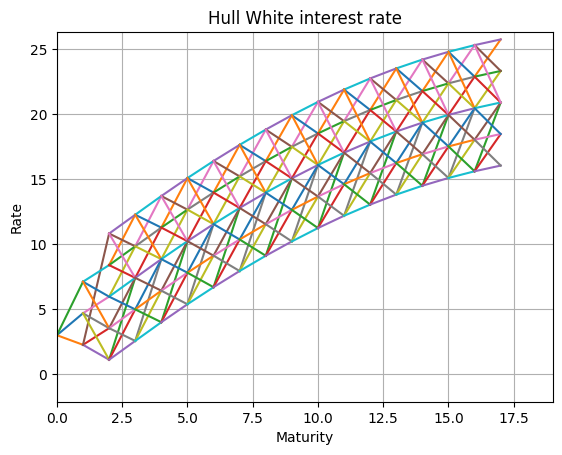

In [9]:
 draw_data(hwc)